In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from category_encoders import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from warnings import filterwarnings
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
import os
import matplotlib.pyplot as plt
import seaborn as sns
filterwarnings('ignore')


In [23]:
# Load data
do_sample = False
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print("train data shape", train.shape)
print("test data shape", test.shape)


train data shape (250, 302)
test data shape (19750, 301)


In [24]:
train.head(2)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973


In [25]:
train_input = train.drop(['id','target'],axis = 1)
test_input  = test.drop(['id'],axis = 1)

train_labels = train['target']

app_train = pd.get_dummies(train_input)
app_test = pd.get_dummies(test_input)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(app_train)
train_imputed = imp_mean.transform(app_train)
test_imputed = imp_mean.transform(app_test)

scaler = StandardScaler()
scaler.fit(train_imputed)
train_imputed = scaler.transform(train_imputed)
test_imputed = scaler.transform(test_imputed)


In [26]:

features = list(app_train.columns)
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(train_imputed,train_labels)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance':feature_importance_values})


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


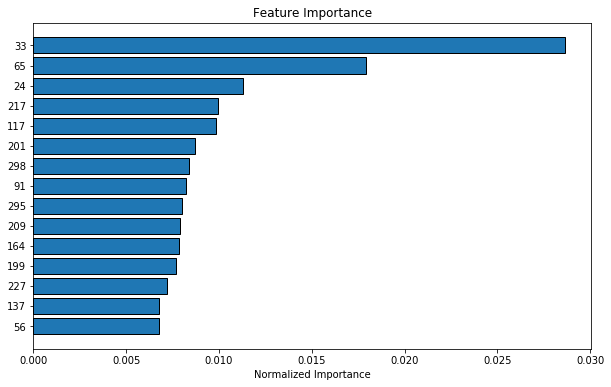

In [27]:
def plot_feature_importances(df):
    #Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    #Normalise the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    #Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10,6))
    ax = plt.subplot()
    
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    #Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    #Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importance')
    plt.show()
    
    return df
feature_importances_sorted = plot_feature_importances(feature_importances)

In [28]:
fe_threshold = 0.001
selected_features = feature_importances_sorted.query('importance_normalized > {}'.format(fe_threshold))['feature'].values
print(selected_features)

['33' '65' '24' '217' '117' '201' '298' '91' '295' '209' '164' '199' '227'
 '137' '56' '268' '214' '43' '144' '80' '189' '266' '139' '48' '230' '111'
 '26' '225' '275' '237' '207' '19' '123' '228' '165' '82' '276' '250'
 '277' '73' '192' '265' '272' '116' '289' '255' '17' '94' '7' '0' '119'
 '156' '12' '131' '285' '169' '147' '242' '247' '16' '170' '149' '240'
 '234' '291' '252' '89' '279' '195' '138' '13' '166' '47' '127' '52' '120'
 '288' '18' '148' '208' '141' '130' '155' '180' '51' '44' '101' '129' '23'
 '113' '37' '150' '132' '173' '202' '76' '239' '58' '163' '257' '215'
 '221' '40' '292' '284' '108' '226' '135' '4' '97' '9' '39' '191' '145'
 '77' '96' '11' '194' '152' '267' '204' '53' '66' '142' '259' '27' '30'
 '160' '231' '270' '98' '248' '42' '8' '278' '110' '185' '114' '256' '153'
 '206' '14' '238' '1' '271' '220' '84' '280' '106' '198' '162' '178' '100'
 '134' '258' '161' '253' '246' '154' '29' '62' '177' '68' '286' '67' '83'
 '200' '236' '78' '122' '118' '21' '171' '151' '1

In [29]:
target_column ='target'
id_column = 'id'
categorical_cols = [c for c in train_input.columns if train_input[c].dtype in [np.object]]
numerical_cols = [c for c in train_input.columns if train_input[c].dtype in [np.float, np.int] and c not in [target_column, id_column]]
preprocess = make_column_transformer(
    (numerical_cols, make_pipeline(SimpleImputer(), StandardScaler())),
    (categorical_cols, OneHotEncoder()))
train_input = preprocess.fit_transform(train_input)
test_input = preprocess.fit_transform(test_input)
print(type(train_input))

<class 'numpy.ndarray'>


In [33]:
classifiers = {
"model_lgbm" : LGBMClassifier(n_jobs=-1,eta=0.01,max_depth=5,max_bin=512,learning_rate=0.01,num_iterations=1000),
"model_xgb" : XGBClassifier(n_jobs=-1, nthreads=-1),
"model_lr" : LogisticRegression(n_jobs=-1),
"model_gnb" : GaussianNB(),
"model_rf" : RandomForestClassifier(n_jobs=-1, random_state=42)
}

In [34]:
def get_fitted_models_and_preds(df, labels, models):
    ret =[]
    for k,v in models.items():
        pred = cross_val_predict(v, df, labels, cv=5, method="predict_proba", n_jobs=-1, verbose=20)
        model = v.fit(df, labels)
        score = roc_auc_score(labels, pred[:,1])
        ret.append({'classifier':k, 'score':score, 'preds':pred, 'model': model})
        print("model {}: {}".format(k,score))
    return ret

In [35]:
def predict_models(df, fitted_base_models):
    ret_df = pd.DataFrame()
    for fitted_base_model in fitted_base_models:
        pred = fitted_base_model['model'].predict_proba(df)
        ret_df[fitted_base_model['classifier']] = pred[:,1]
    return ret_df

In [36]:
base_models_preds_train = get_fitted_models_and_preds(train_input, train_labels, classifiers)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


model model_lgbm: 0.7100694444444443


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


model model_xgb: 0.7004861111111111


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


model model_lr: 0.741736111111111


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1857s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


model model_gnb: 0.7038888888888889
model model_rf: 0.5668402777777778


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [37]:
df_base_model_preds_train = pd.DataFrame({base_model_pred_train['classifier']:base_model_pred_train['preds'][:,1] for base_model_pred_train in base_models_preds_train})
print(df_base_model_preds_train.head())
print(df_base_model_preds_train.shape)
print(train_labels.shape)

   model_gnb  model_lgbm  model_lr  model_rf  model_xgb
0   0.999991    0.978889  0.706580       1.0   0.887592
1   0.993715    0.897000  0.195855       0.4   0.876891
2   0.530346    0.886438  0.165840       0.7   0.885498
3   0.997975    0.979355  0.944564       0.7   0.720474
4   0.997797    0.777789  0.970883       0.6   0.768202
(250, 5)
(250,)


In [38]:
second_level_classifier_gbm = XGBClassifier(
 #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

second_level_model= second_level_classifier_gbm.fit(df_base_model_preds_train, train_labels)


In [39]:
ensemble_preds_train = second_level_model.predict_proba(df_base_model_preds_train)
print(ensemble_preds_train[:,1])
ensemble_preds_score = roc_auc_score(train_labels, ensemble_preds_train[:,1])
print(ensemble_preds_score)


[0.9785459  0.28489077 0.8280892  0.9921725  0.9780226  0.8656173
 0.991702   0.97244287 0.8540545  0.88790506 0.01561387 0.9855117
 0.96044517 0.09835116 0.04482976 0.9986941  0.78654677 0.11878137
 0.9989373  0.9602168  0.8828359  0.9943792  0.02890524 0.7775818
 0.8486121  0.84406835 0.99265903 0.8584219  0.9697389  0.6276887
 0.8958335  0.9089668  0.85556626 0.90608627 0.98733276 0.91215974
 0.8907769  0.9174375  0.11738426 0.7129249  0.99867743 0.9310155
 0.82409084 0.06948008 0.950576   0.97067326 0.9113206  0.9024523
 0.08143407 0.09681522 0.78844583 0.8740805  0.1262717  0.9225068
 0.20662516 0.8679902  0.11574811 0.98271906 0.20938759 0.26373172
 0.8637745  0.7253376  0.52488536 0.04986462 0.08124271 0.9240162
 0.40056917 0.97426003 0.8963074  0.9895862  0.08885325 0.98969495
 0.9881045  0.8962298  0.95176023 0.22181703 0.99066544 0.90206605
 0.13961928 0.8447279  0.9080985  0.15721212 0.2413914  0.94571334
 0.9349292  0.9944595  0.03696557 0.85229814 0.9190432  0.9735454
 0.9

In [43]:
df_test_base_model_preds = predict_models(test_input, base_models_preds_train)
print(df_test_base_model_preds.shape)
df_test_base_model_preds_col_ordered = pd.DataFrame()
for col in df_base_model_preds_train.columns:
    df_test_base_model_preds_col_ordered[col] = df_test_base_model_preds[col]
ensemble_preds_test = second_level_classifier_gbm.predict_proba(df_test_base_model_preds_col_ordered)
print(ensemble_preds_test.shape)

(19750, 5)
(19750, 2)


In [46]:
sub = pd.read_csv("data/sample_submission.csv")
print(ensemble_preds_test.shape)
print(sub.shape)

sub[target_column] = ensemble_preds_test[:,1]
sub.to_csv("results/submit_results.csv", index=False)
print('done')

(19750, 2)
(19750, 2)
done


In [50]:
%%bash
kaggle competitions submit -c dont-overfit-ii -f results/submit_results.csv -m "initial"

Successfully submitted to Don't Overfit! II

100%|██████████| 308k/308k [00:01<00:00, 196kB/s] 
